In [63]:
#Importing all necessary packages
import warnings #Ignore warnings
warnings.simplefilter("ignore", UserWarning)


import pandas as pd
import numpy as np

#Plotting
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
import seaborn as sns
sns.set_style('darkgrid')


#scikit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

In [64]:
df = pd.read_csv('AMZN_stock_data.csv')

# EDA and Trend Analysis

In [65]:
print(df.shape)

df.describe()

(6987, 8)


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,6987.000000,6987.000000,6987.000000,6987.000000,6.987000e+03,6987.0,6987.000000
mean,40.692696,41.165619,40.178290,40.685061,1.360552e+08,0.0,0.003864
std,58.144182,58.787641,57.435304,58.125169,1.375735e+08,0.0,0.244286
min,0.070313,0.072396,0.065625,0.069792,9.744000e+06,0.0,0.000000
25%,2.100250,2.148250,2.064250,2.110000,6.298900e+07,0.0,0.000000
50%,9.041500,9.158500,8.925000,9.021000,1.005360e+08,0.0,0.000000
75%,72.789249,73.643497,71.504250,73.006500,1.555070e+08,0.0,0.000000
max,239.020004,242.520004,238.029999,242.059998,2.086584e+09,0.0,20.000000


## Data Cleaning/Preprocessing ## 

In [66]:
#Converting date to datetime
df['Date'] = pd.to_datetime(df['Date'], utc = True)

#Checking datatypes and missing values
print(df.info())



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6987 entries, 0 to 6986
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype              
---  ------        --------------  -----              
 0   Date          6987 non-null   datetime64[ns, UTC]
 1   Open          6987 non-null   float64            
 2   High          6987 non-null   float64            
 3   Low           6987 non-null   float64            
 4   Close         6987 non-null   float64            
 5   Volume        6987 non-null   int64              
 6   Dividends     6987 non-null   float64            
 7   Stock Splits  6987 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(6), int64(1)
memory usage: 436.8 KB
None


In [67]:
df.head(10)
print(f'Entries with 0 dividends: {(df['Dividends'] == 0).sum()}')
print(f'Entries with 0 Stock Splits: {(df['Stock Splits'] == 0).sum()}')

Entries with 0 dividends: 6987
Entries with 0 Stock Splits: 6983


## Removing the irrelevant variables, Creating Moving Average Features

In [68]:
df2 = df.drop(columns = ['Dividends', 'Stock Splits']) #removed unusable features
df2['50_SMA'] = df2['Close'].rolling(window = 50).mean() #moving averages
df2['200_SMA'] = df2['Close'].rolling(window = 200).mean()


## Plotting Closing price Against Trends in Moving Averages

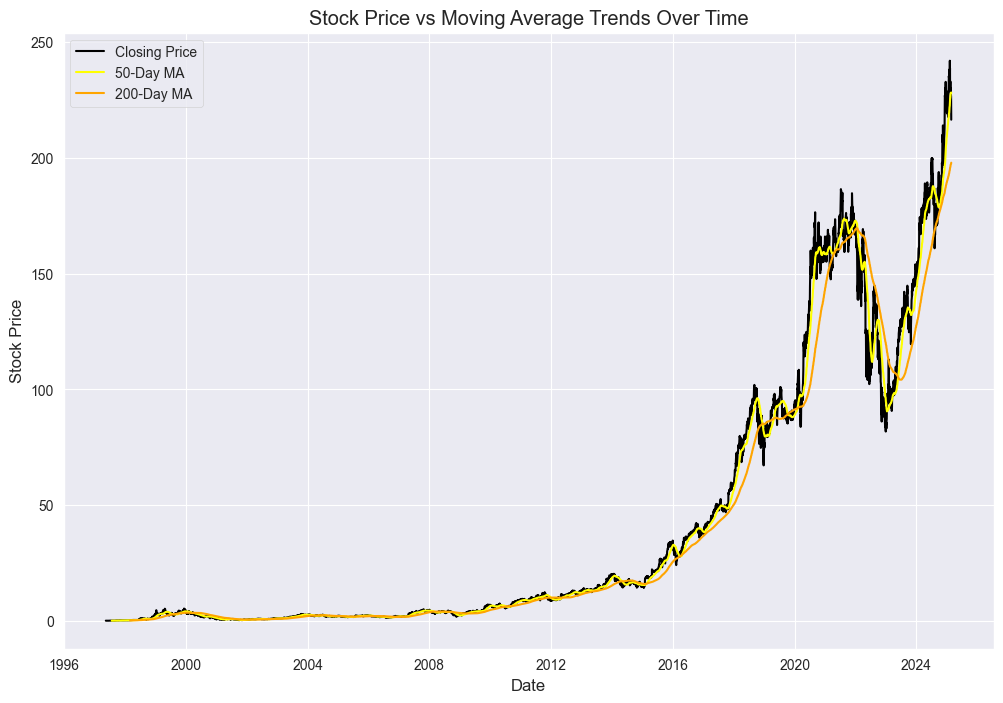

In [69]:
plt.figure(figsize=(12, 8))
plt.plot(df2['Date'], df2['Close'], label="Closing Price", color="black")
plt.plot(df2['Date'], df2['50_SMA'], label="50-Day MA", color="yellow")
plt.plot(df2['Date'], df2['200_SMA'], label="200-Day MA", color="orange")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.legend()
plt.title("Stock Price vs Moving Average Trends Over Time")
plt.show()
#buy/sell signals seem to be accurate at key moments

# Preparation for Linear Regression 

## Plotting a Correlation Matrix and Pairplot

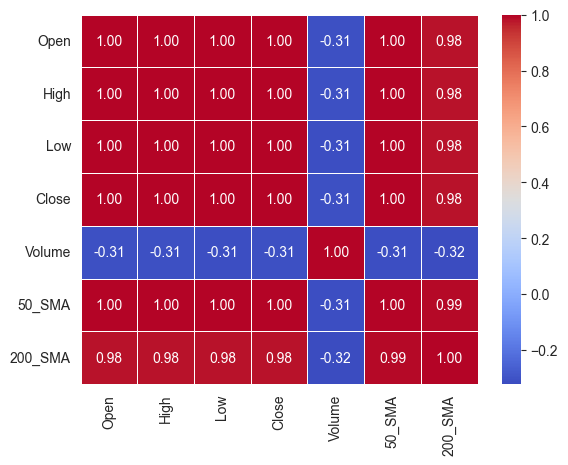

In [70]:
corr_matrix = df2.loc[:, 'Open':].corr() #Heatmap shows heavy collinearity between the majority of variables
corr_matrix
sns.heatmap(corr_matrix, cmap = 'coolwarm',  annot=True, fmt=".2f", linewidths=0.7)
plt.show() # From this heatmap, we expect highly accurate linear model results

## Splitting Data into Training and Testing Sets (No TimeSeriesSplit First)

In [71]:
df3 = df.set_index('Date')
X = df3[['Open', 'High', 'Low', 'Volume']]
y = df3['Close']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = False)


## Min-Max Feature Scaling and Linear Model Deployment

In [72]:
#Apply minmax feature scaling, Kaggle dataset showed us shared skewness of every variable,
# as well as volume using a different scale. Plot residuals after linear regression for verification.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [73]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

y_train_pred = model.predict(X_train_scaled)
y_test_pred = model.predict(X_test_scaled)


r_squared_train = r2_score(y_train, y_train_pred)
r_squared_test = r2_score(y_test, y_test_pred)
mse_train = mean_squared_error(y_train, y_train_pred)
mse_test = mean_squared_error(y_test, y_test_pred)

print(f'r-squared(train): {r_squared_train}')
print(f'mse(train): {mse_train}')

print(f'r-squared(test): {r_squared_test}')
print(f'mse(test): {mse_test}') #Testing Set MSE is much higher than training due to high stock volatility during the last few years


r-squared(train): 0.99994738475895
mse(train): 0.027844214641742037
r-squared(test): 0.9992134993497799
mse(test): 1.0494825511915458


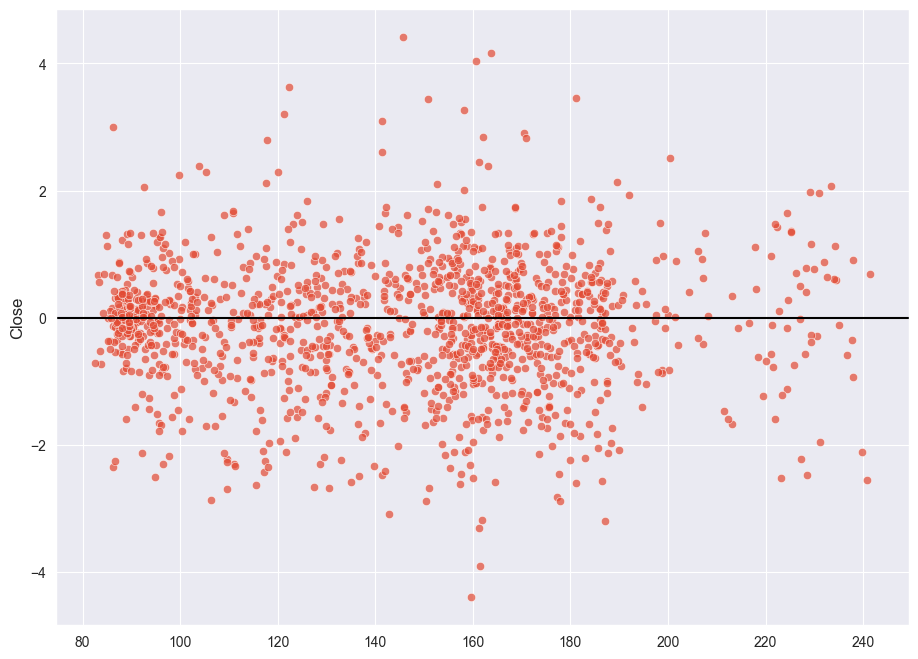

In [74]:
residuals = y_test - y_test_pred

plt.figure(figsize=(11,8)) #Resiual scatterplot
sns.scatterplot(x=y_test_pred, y=residuals, alpha =0.7)
plt.axhline(y=0, color ='black')
plt.show()

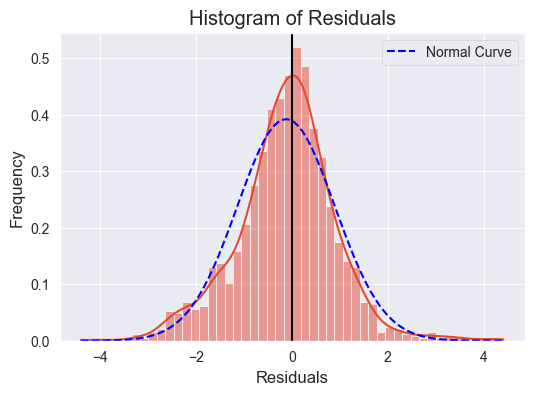

In [75]:
from scipy.stats import norm
plt.figure(figsize=(6, 4)) #residuals distribution
sns.histplot(residuals, bins=50, stat='density', kde = True)
plt.axvline(x=0, color='black')
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.title("Histogram of Residuals")



# plt.hist(residuals, density = 1, bins = 50, label = 'Residuals') #histogram of residuals
mean, std = norm.fit(residuals)
normal_dist = np.linspace(residuals.min(), residuals.max(), 100)
plt.plot(normal_dist, norm.pdf(normal_dist, mean, std), 'b--', label="Normal Curve") #normal curve
plt.legend()
plt.show()

# Plotting predictions Against Real Prices

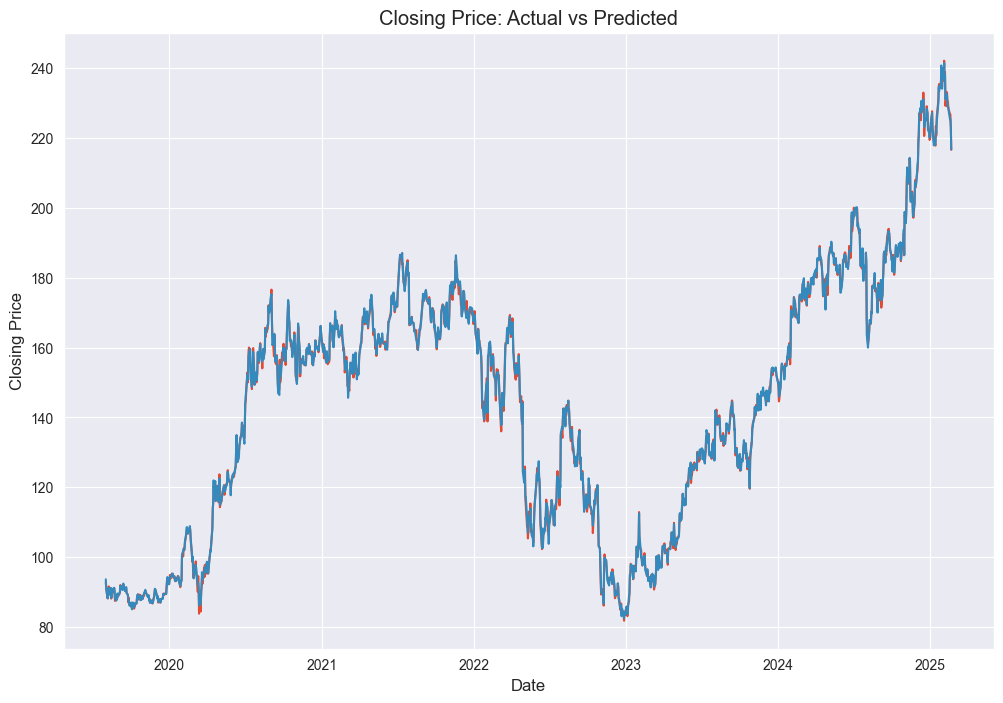

In [112]:
test_dates = X_test.index
plt.figure(figsize=(12,8))
plt.plot(test_dates, y_test)
plt.plot(test_dates, y_test_pred)
plt.xlabel("Date")
plt.ylabel("Closing Price")
plt.title("Closing Price: Actual vs Predicted")
plt.show() #plot shows that data is HIGHLY linear